# Lecture #11 Seminar "WaveNet inference" 🌊


The purpose of this seminar is to immerse you in WaveNet architecture. In the lecture we discussed in detail WaveNet architecture, so you can easily write an autoregressive inference function.

<img src="https://www.researchgate.net/profile/Mark-Hasegawa-Johnson/publication/311106829/figure/fig3/AS:433958858039299@1480475262377/The-caching-scheme-for-efficient-generation-Due-to-dilated-convolutions-the-size-of-the.png" alt="Drawing" style="width: 60%;"/>

In [1]:
from IPython.display import Audio
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

from scipy.io.wavfile import read
from scipy.signal import lfilter
from queue import Queue

import numpy as np
import librosa

import torch
import torch.nn as nn

## DSP utils 

"D" in "Deep Learning" stands for data and "e" for "engineering" 🙃, so we need to implement some basic data preprocessing functions. Specifically we need to implement proper conversion from signal to mel spectrogram.

All preprocessing functions are already implemented, but we don't want you to pass them by 😏. So you need to implement their reverse counterparts.

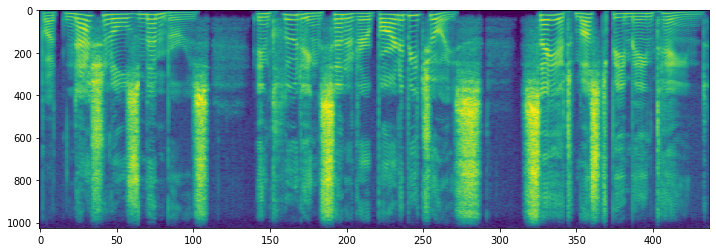

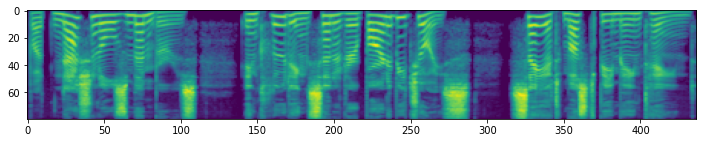

In [72]:
class AudioProcessor:
    MAX_WAV_VALUE = 32768.0

    def __init__(self):
        num_frequencies = 1025
        self.sample_rate = 24000
        self.window_size = int(self.sample_rate * 0.05)
        self.window_step = self.window_size // 4
        self.n_fft = (num_frequencies - 1) * 2
        self.preemphasis_coef = 0.97
        self.min_frequency = 50
        self.max_frequency = 12000
        self.num_mel_bins = 80
        self.ref_level_db = 20
        self.min_level_db = -100
        
        self.min_level = np.exp(self.min_level_db / 20 * np.log(10))

        self.mel_basis = librosa.filters.mel(
            self.sample_rate,
            n_fft=self.n_fft,
            n_mels=self.num_mel_bins,
            fmin=self.min_frequency,
            fmax=self.max_frequency)
        self.inv_mel_basis = np.linalg.pinv(self.mel_basis)
        
    def load_wav(self, path):
        sr, signal = read(path)
        if signal.dtype == np.int16:
            signal = signal.astype(np.float32) / self.MAX_WAV_VALUE
        assert sr == self.sample_rate
        return signal

    def stft(self, y):
        return librosa.stft(y,
            n_fft=self.n_fft,
            hop_length=self.window_step,
            win_length=self.window_size)

    def istft(self, y):
        #####
        # ...
        #####
        return librosa.istft(y,
            n_fft=self.n_fft,
            hop_length=self.window_step,
            win_length=self.window_size)

    def pre_emphasis(self, x):
        return librosa.effects.preemphasis(x, coef=self.preemphasis_coef)  # lfilter([1, -self.preemphasis_coef], [1], x)

    def de_emphasis(self, x):
        #####
        return librosa.effects.deemphasis(x, coef=self.preemphasis_coef)
        #####

    def amp_to_db(self, x):
        x = np.maximum(self.min_level, x)
        return 20 * np.log10(x) - self.ref_level_db

    def db_to_amp(self, x):
        #####
        return np.power(10, (x + self.ref_level_db) / 20.0)
        #####

    def normalize(self, S):
        return np.clip((S - self.min_level_db) / -self.min_level_db, 0, 1)

    def inv_normalize(self, S):
        #####
        return (S * -self.min_level_db)  + self.min_level_db
        #####
        pass

    def linear_to_mel(self, S):
        return np.dot(self.mel_basis, S)

    def mel_to_linear(self, M):
        #####
        return np.dot(self.inv_mel_basis, M)
        #####

    def spectrogram(self, y):
        S = np.abs(self.stft(y))
        S = self.amp_to_db(S)
        return self.normalize(S)

    def inv_spectrogram(self, S):
        #####
        S = self.inv_normalize(S)
        S = self.db_to_amp(S)
        y = self.griffin_lim(S)
        return y
        #####
    
    def mel_spectrogram(self, y):
        S = np.abs(self.stft(y))
        M = self.linear_to_mel(S)
        M = self.amp_to_db(M)
        return self.normalize(M)

    def inv_mel_spectrogram(self, M):
        #####
        M = self.inv_normalize(M)
        M = self.db_to_amp(M)
        M = self.mel_to_linear(M)
        S = self.griffin_lim(M)
        return S
        #####

    def griffin_lim(self, x, num_iter=20):
        # not the first time, I know :)
        #####
        return librosa.griffinlim(x, n_iter=num_iter)
        #####

    def mu_law_encode(self, x, mu_quantization=256):
        #####
        assert(np.max(x) <= 1.0)
        assert(np.min(x) >= -1.0)
        mu = mu_quantization - 1.
        scaling = np.log1p(mu)
        x_mu = np.sign(x) * np.log1p(mu * np.abs(x)) / scaling
        encoding = ((x_mu + 1) / 2 * mu + 0.5)
        return encoding
        #####

    def mu_law_decode(self, x, mu_quantization=256):
        #####
        assert(np.max(x) <= mu_quantization)
        assert(np.min(x) >= 0)
        x = np.array(x, dtype=np.float32)
        mu = mu_quantization - 1.
        # Map values back to [-1, 1].
        signal = 2 * (x / mu) - 1
        # Perform inverse of mu-law transformation.
        magnitude = (1 / mu) * ((1 + mu)**np.abs(signal) - 1)
        return np.sign(signal) * magnitude
        #####
    
ap = AudioProcessor()

x = ap.load_wav('./samples/00000.wav')
spec = ap.spectrogram(ap.pre_emphasis(x))
mel = ap.mel_spectrogram(ap.pre_emphasis(x))

plt.figure(figsize=(12, 4))
plt.imshow(spec, aspect='auto')
plt.show()

plt.figure(figsize=(12, 2))
plt.imshow(mel, aspect='auto')
plt.show()

In [47]:
# check that all tests are passed

x = ap.load_wav('./samples/00000.wav')

assert np.abs(ap.de_emphasis(ap.pre_emphasis(x)) - x).max() < 1e-7

assert ap.mu_law_encode(-1.0) == 0
assert ap.mu_law_encode(0.0) == 128
assert ap.mu_law_encode(0.5) == 239
assert ap.mu_law_encode(1.0) == 255
for i in range(256):
    assert ap.mu_law_encode(ap.mu_law_decode(i)) == i

# make sure the quality does not degrade too much
display(Audio(x, rate=ap.sample_rate))
display(Audio(ap.inv_spectrogram(ap.spectrogram(x)), rate=ap.sample_rate))
display(Audio(ap.inv_mel_spectrogram(ap.mel_spectrogram(x)), rate=ap.sample_rate))

AssertionError: 

In [50]:
ap.mu_law_encode(-1.0)

-128

## Griffin-Lim with the synthesised 🌮 mels

Hear how the result of Griffin-Lim sounds, not just on mel spectrograms, but on **generated** mel spectrograms. But it was generated using teacher forcing, otherwise it will not be possible to accurately correlate the frames.

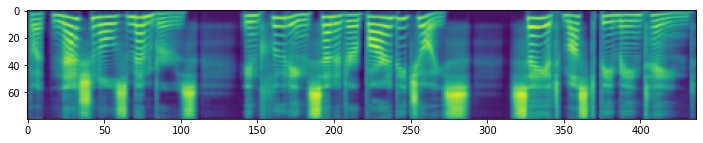

In [41]:
x = ap.load_wav('./samples/00000.wav')
m = np.load('./samples/00000.npy')

plt.figure(figsize=(12, 2))
plt.imshow(m.T, aspect='auto')
plt.show()

display(Audio(x, rate=ap.sample_rate))
# display(Audio(ap.de_emphasis(ap.inv_mel_spectrogram(m.T)), rate=ap.sample_rate))
display(Audio(ap.de_emphasis(ap.inv_mel_spectrogram(m.T)), rate=ap.sample_rate))

## WaveNet

Read the code carefully

In [53]:
class CausalConv1d(nn.Conv1d):
    def __init__(self, *args, **kwargs):
        super(CausalConv1d, self).__init__(*args, **kwargs)
        self.padding = ((self.kernel_size[0] - 1) * self.dilation[0],)

    def forward(self, x):
        x = super(CausalConv1d, self).forward(x)
        return x[:, :, :-self.padding[0]]


class WaveNet(nn.Module):
    """WaveNet architecture with local conditioning

    https://arxiv.org/pdf/1609.03499.pdf - original paper
    https://arxiv.org/pdf/1702.07825.pdf - appending A for more details
    
    But given implementation has following differences:
    1. tanh is not applied to input embedding
    2. vector is scaled (multiplied 0.5 ** 0.5) between blocks
    3. GRU is used for processing mel spectrogram
    4. GRU output is nearest neighbour apsampled hop_size times
    5. each block has own conditioning projection

    Args:
        num_channels       (int): size of modelled categorical distribution
        residual_channels  (int): hidden vector size
        gate_channels      (int): gate block dimension
        skip_channels      (int): skip-vector size
        pre_channels       (int): dimension before the last layer
        dilation_cycles    (int): number of dilation cycles
        dilation_depth     (int): blocks number in dilation cycle
        condition_channels (int): number of mel filters
        hop_size           (int): STFT hop size
    """

    def __init__(self,
                 num_channels,
                 residual_channels,
                 gate_channels,
                 skip_channels,
                 pre_channels,
                 dilation_cycles,
                 dilation_depth,
                 condition_channels,
                 hop_size):
        super(WaveNet, self).__init__()
        
        self.kernel_size = 2
        self.dilations = np.array([
            2 ** (i % dilation_depth) 
            for i in range(dilation_cycles * dilation_depth)
        ])

        self.n_layers = dilation_cycles
        self.num_channels = num_channels
        self.residual_channels = residual_channels
        self.gate_channels = gate_channels
        self.skip_channels = skip_channels
        self.pre_channels = pre_channels
        self.hop_size = hop_size
        
        self.condition_net = nn.GRU(
            input_size=condition_channels,
            hidden_size=condition_channels // 2,
            num_layers=2,
            batch_first=True,
            bidirectional=True)
        
        self.conv_input = nn.Conv1d(
            in_channels=num_channels,
            out_channels=residual_channels,
            kernel_size=1)

        self.blocks_conv_filter = nn.ModuleList([
            CausalConv1d(
                in_channels=residual_channels,
                out_channels=gate_channels,
                kernel_size=2,
                dilation=d
            ) for d in self.dilations])

        self.blocks_conv_gate = nn.ModuleList([
            CausalConv1d(
                in_channels=residual_channels,
                out_channels=gate_channels,
                kernel_size=2,
                dilation=d
            ) for d in self.dilations])
        
        self.blocks_conv_residual = nn.ModuleList([
            nn.Conv1d(
                in_channels=gate_channels,
                out_channels=residual_channels,
                kernel_size=1
            ) for _ in range(len(self.dilations) - 1)])
        
        self.blocks_conv_skip = nn.ModuleList([
            nn.Conv1d(
                in_channels=gate_channels,
                out_channels=skip_channels,
                kernel_size=1
            ) for _ in range(len(self.dilations))])
        
        self.blocks_conv_cond = nn.ModuleList([
            nn.Conv1d(
                in_channels=condition_channels,
                out_channels=gate_channels * 2,
                kernel_size=1
            ) for _ in range(len(self.dilations))])
        
        self.conv_out_1 = nn.Conv1d(
            in_channels=skip_channels,
            out_channels=pre_channels,
            kernel_size=1)
        self.conv_out_2 = nn.Conv1d(
            in_channels=pre_channels,
            out_channels=num_channels,
            kernel_size=1)

    def forward(self, x, c):
        """
        Args:
            x (FloatTensor): continuous audio signal [B x K x T]
            c (FloatTensor): local condition features [B x L x C],
                where L = T // 300

        Returns:
            FloatTensor: output [B x out_channels x T]
        """
        
        x = self.conv_input(x)
        c, _ = self.condition_net(c)
        c = c.transpose(1, 2)

        c = nn.functional.interpolate(c,
            scale_factor=self.hop_size,
            mode='nearest')

        assert c.size(2) == x.size(2)

        x_acc = 0
        for b in range(len(self.dilations)):
            x_filter = self.blocks_conv_filter[b](x)
            x_gate = self.blocks_conv_gate[b](x)

            cond = self.blocks_conv_cond[b](c)
            c_filter, c_gate = cond.chunk(chunks=2, dim=1)
            x_filter += c_filter
            x_gate += c_gate

            x_hidden = torch.tanh(x_filter) * torch.sigmoid(x_gate)

            x_skip = self.blocks_conv_skip[b](x_hidden)
            x_acc = x_acc + x_skip

            if b < len(self.dilations) - 1:
                x_residual = self.blocks_conv_residual[b](x_hidden)
                x = x + x_residual

            x = x * 0.5 ** 0.5
            

        x = self.conv_out_1(torch.relu(x_acc))
        x = self.conv_out_2(torch.relu(x))

        return x

    def get_cond_input(self, features):
        """
        Takes in features and gets the 2*R x batch x # layers x samples tensor
        """
        # TODO(rcosta): trim conv artifacts. mauybe pad spec to kernel multiple
        cond_input = self.upsample(features)
        time_cutoff = self.upsample.kernel_size[0] - self.upsample.stride[0]
        cond_input = cond_input[:, :, :-time_cutoff]
        cond_input = self.cond_layers(cond_input).data
        cond_input = cond_input.view(cond_input.size(0), self.n_layers, -1, cond_input.size(2))
        # This makes the data channels x batch x num_layers x samples
        cond_input = cond_input.permute(2,0,1,3)
        return cond_input

In [54]:
model = WaveNet(
    num_channels=256,
    residual_channels=64,
    gate_channels=64,
    skip_channels=128,
    pre_channels=256,
    dilation_cycles=4,
    dilation_depth=10,
    condition_channels=80,
    hop_size=300)
model.load_state_dict(torch.load('./state_dict.pth'))

<All keys matched successfully>

In [55]:
def one_hot(x, num_channels):
    x_o = torch.FloatTensor(x.shape[0], num_channels, x.shape[1])
    x_o.zero_().scatter_(1, x.unsqueeze(1), 1)
    return x_o

def calc_loss(model, x, c):
    x_o = one_hot(x, model.num_channels)
    y = model.forward(x_o, c).transpose(1, 2)

    loss = nn.functional.cross_entropy(
        y[:, :-1].contiguous().view(-1, y.shape[-1]),
        x[:, 1:].contiguous().view(-1))
    
    return loss

with torch.no_grad():
    x = ap.load_wav('./samples/00000.wav')
    c = np.load('./samples/00000.npy')
    
    # cut off to be a multiple of the window step
    c = c[:len(x) // ap.window_step]
    x = x[:len(c) * ap.window_step]

    # apply mu-law encoding
    x = ap.mu_law_encode(x)

    x = torch.LongTensor(x)
    c = torch.FloatTensor(c)

    loss = calc_loss(model, x.unsqueeze(0), c.unsqueeze(0)).item()

assert np.allclose(loss, 1.7863293886184692)

# WaveNet Inference 

You need to implement the `infer` function, which synthesizes the audio from the `mel` spectrogram by the `model` model. The output of this function is mu-law encoded signal.

**Important note**: as you can see from the code, we calculate spectrograms passing them through the pre-emphasis filter. It so happened (obviously by mistake) that although WaveNet learned with such spectrograms, but the audio signal for was not passed through the pre-emphasis filter. So you **do not need** to pass WaveNet output through de-emphassis filter.

Hints:
1. debug on short spectra (30-40 frames long)
2. parse network to get matrices and vectors -- it's easier to work directly with them
3. sanity check matrices sizes that they have expected shapes

In [76]:
def infer(implementation, inp):
    #####
    cond_input = inp.unsqueeze(0)
    x_o = one_hot(cond_input, model.num_channels)
    y = model.forward(x_o, cond_input).transpose(1, 2)
    #####


x = ap.load_wav('./samples/00000.wav')
c = np.load('./samples/00000.npy')
c = c[:len(x) // ap.window_step]
x = x[:len(c) * ap.window_step]
x_enc = ap.mu_law_encode(x)
x_enc = torch.LongTensor(x_enc)
x_enc = x_enc.unsqueeze(0)
c = torch.FloatTensor(c).unsqueeze(0)

x_o = one_hot(x_enc, model.num_channels)
y = model.forward(x_o, c).squeeze(0).transpose(0, 1)
x_gen = ap.mu_law_decode(torch.argmax(y, axis=-1).numpy())
# x_gen = infer(model, )))

display(Audio(x, rate=ap.sample_rate))
display(Audio(x_gen, rate=ap.sample_rate))